# Spotted!

AC215: Productionizing AI (MLOps)

Sunil Chomal, Alex Coward, Olga Leushina, Jonathan Sessa

## Model Training using WanDB

##**I. Environment Setup**

###I-1 Installs

In [1]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.1 MB/s eta 0:00:00


In [2]:
# Install GCS Fuse
!echo "deb https://packages.cloud.google.com/apt gcsfuse-$(lsb_release -c -s) main" | tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2659  100  2659    0     0   5751      0 --:--:-- --:--:-- --:--:--  5755
OK
22 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 22 not upgraded.
Need to get 5,558 kB of archives.
After this operation, 0 B of additional disk space will be used.
Selecting previously unselected package g

###I-2 Imports

In [3]:
# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Libraries
import random as rn
import numpy as np
from scipy import stats as st

# File and System Libraries
import os
import pickle
import pathlib
import time

# TensorFlow Libraries
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, AveragePooling2D, GlobalAvgPool2D, Dense, Add, Flatten, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.activations import relu
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.python.keras import backend as K

# SKLearn Dataset Management and Model Evaluation Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Tensorflow Hub
import tensorflow_hub as hub

# Google Cloud
from google.colab import drive
from google.colab import auth

from functools import partial

# Dask
import dask
import dask.dataframe as dd
import dask.delayed as delayed

# W&B
import wandb
from wandb.keras import WandbCallback, WandbMetricsLogger

###I-3 Verify setup

In [4]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately,
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

tensorflow version 2.14.0
Eager Execution Enabled: True
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
!nvidia-smi

Tue Oct 24 19:18:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W /  70W |    385MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##**II. Dataset load and analysis**

###II-1 Load data into tf records

In [6]:
# Authenticate Google Cloud access using current account
auth.authenticate_user()

# NOTE: We can use the above method to authenticate in a notebook, but when
# using a container for serverless training, you'll need to use a secrets file:
# gcsfuse --key-file=/secrets/service-account.json /$GCS_BUCKET_NAME

# Create local directory and mound GCS bucket
!mkdir buckets

# Dynamically mount GCS to local directory
!gcsfuse buckets

{"time":"24/10/2023 07:19:15.565610","severity":"INFO","msg":"Start gcsfuse/1.2.0 (Go version go1.21.0) for app \"\" using mount point: /content/buckets\n"}


In [7]:
# Path to TFRecords in GCS bucket
GCS_PATH = "./buckets/dog-breeds-224/processed"

train_tfr_files = tf.io.gfile.glob(GCS_PATH + "/train_*.tfrecords")
val_tfr_files = tf.io.gfile.glob(GCS_PATH + "/val_*.tfrecords")
test_tfr_files = tf.io.gfile.glob(GCS_PATH + "/test_*.tfrecords")

In [8]:
# Load CSV data from Google Bucket
csv_of_all_images = "./buckets/dog-breeds-224/preprocessed/csv/all-data.csv"
df = dd.read_csv(csv_of_all_images, dtype={'filename': 'object', 'label': 'object'})

# Get unique breeds from dataset
breeds = np.unique(df['label'].compute())
print(f'Number of breeds: {len(breeds)}')

# Number of unique labels
NUM_CLASSES = len(breeds)

# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(breeds))
index2label = dict((index, name) for index, name in enumerate(breeds))

Number of breeds: 149


In [9]:
# Helper functions for reading dataset from TFRecords
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 64
IMAGE_SIZE = [224, 224]

# Decode and normalize image
def decode_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.cast(image, tf.float32)
  image = tf.reshape(image, [*IMAGE_SIZE, 3])

  return image

@tf.function
def read_tfrecord(example):
    tfrecord_format = (
        {
            "image": tf.io.FixedLenFeature([], tf.string),
            "label": tf.io.FixedLenFeature([], tf.int64),
        }
    )

    example = tf.io.parse_single_example(example, tfrecord_format)

    # Decode image from bytes
    image = decode_image(example["image"])

    # One hot encoding for lables
    label = example["label"]
    label = tf.one_hot(label, NUM_CLASSES)

    return image, label

def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed

    # Automatically interleaves reads from multiple files
    dataset = tf.data.TFRecordDataset(filenames)

    # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.with_options(ignore_order)

    # Returns a dataset of (image, label)
    dataset = dataset.map(partial(read_tfrecord), num_parallel_calls=AUTOTUNE)

    return dataset

def get_dataset(filenames):
    dataset = load_dataset(filenames)
    dataset = dataset.shuffle(1024)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [10]:
train_ds = get_dataset(train_tfr_files)
val_ds = get_dataset(val_tfr_files)
test_ds = get_dataset(test_tfr_files)

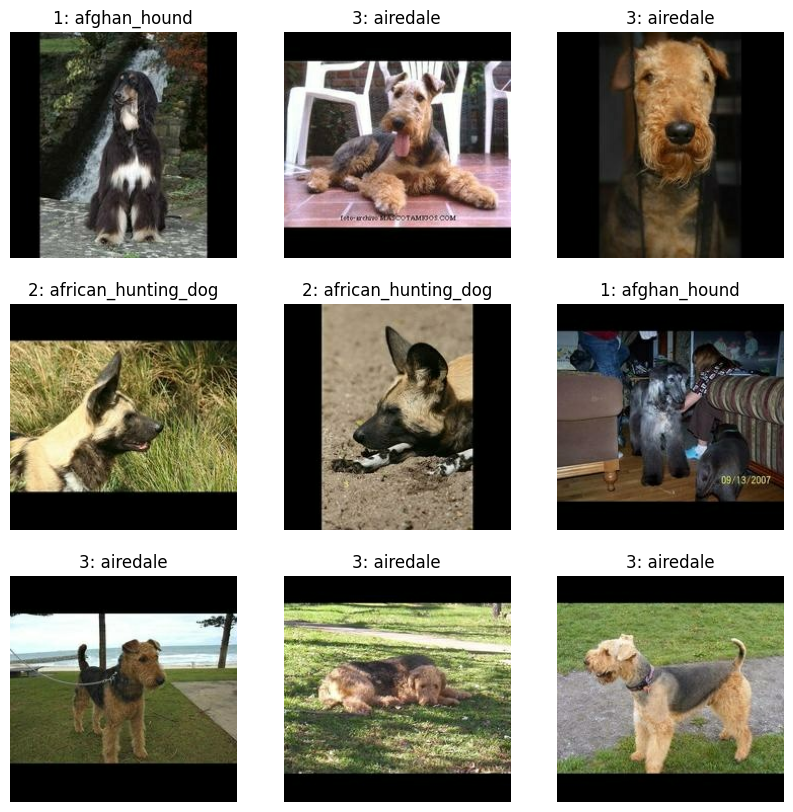

In [11]:
# Verify Images/Lables are extracted correctly
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))

    for n in range(9):
        ax = plt.subplot(3, 3, n + 1)

        # Normalize image before displaying
        plt.imshow(image_batch[n]/255)

        # Decode one-hot label
        id = np.argmax(label_batch[n])
        plt.title(f'{id}: {index2label[id]}')

        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## Model Test (Just to make sure datasets work)

In [12]:
# Just a quick test to see if model runs
model_name = "EfficientNetV2_train_base"
IMG_SIZE = 224

In [13]:
def make_model():
  base_model = keras.applications.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    include_preprocessing=False
  )

  # Freeze model weights for baseline evaluation
  base_model.trainable = False

  # Input Layer
  inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

  # Scales input from (0, 255) to a range of (-1., +1.) for EfficientNet
  x = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputs)

  # EfficientNet Base model (freezing batch normalization layers)
  x = base_model(x)

  x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
  x = layers.BatchNormalization()(x)

  # One nodes for categorical classification
  outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax", name="prediction")(x)

  # Create model
  baseline_model = keras.Model(inputs=inputs, outputs=outputs, name='baseline_model')

  # Compile the model
  baseline_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=CategoricalCrossentropy(),
    metrics=["accuracy"]
  )

  return baseline_model

In [14]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

print("Number of replicas:", strategy.num_replicas_in_sync)

Number of replicas: 1


In [15]:
with strategy.scope():
    model = make_model()

history = model.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds
)

24274472/24274472 [==============================] - 0s 0us/step
Epoch 1/5
1050/1050 [==============================] - 177s 150ms/step - loss: 2.5853 - accuracy: 0.6319 - val_loss: 8.9353 - val_accuracy: 0.1472
Epoch 2/5
1050/1050 [==============================] - 154s 146ms/step - loss: 1.6873 - accuracy: 0.6807 - val_loss: 5.3297 - val_accuracy: 0.2468
Epoch 3/5
1050/1050 [==============================] - 154s 146ms/step - loss: 1.2142 - accuracy: 0.7326 - val_loss: 4.5297 - val_accuracy: 0.2668
Epoch 4/5
1050/1050 [==============================] - 157s 131ms/step - loss: 1.0569 - accuracy: 0.7575 - val_loss: 4.1052 - val_accuracy: 0.2797
Epoch 5/5
1050/1050 [==============================] - 139s 132ms/step - loss: 0.9821 - accuracy: 0.7731 - val_loss: 4.0785 - val_accuracy: 0.2700


In [33]:
def show_batch_predictions(image_batch, label_batch):
    plt.figure(figsize=(10, 10))

    for n in range(9):
        ax = plt.subplot(3, 3, n + 1)
        plt.imshow(image_batch[n] / 255.0)

        # Get model prediction and decode output
        img = tf.expand_dims(image_batch[n], axis=0)
        pred = model.predict(img)

        id = np.argmax(pred)
        true_id = np.argmax(label_batch[n])
        plt.title(f'{id}: {index2label[id]} \n True: {true_id}: {index2label[true_id]}')

        plt.axis("off")

1/1 [==============================] - 0s 48ms/step


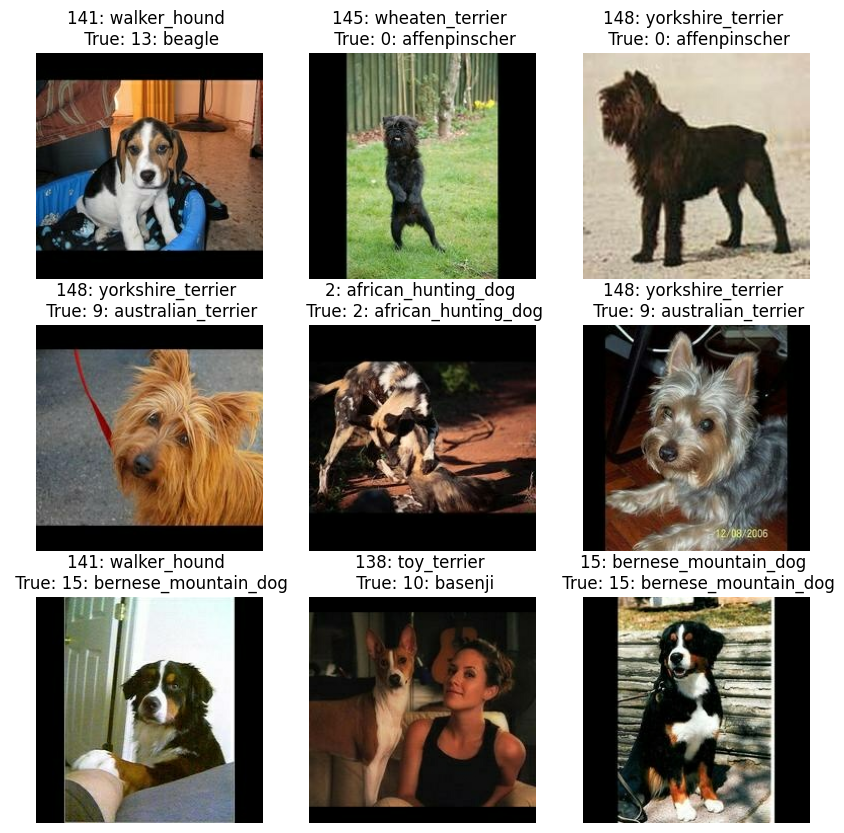

In [34]:
# Example model predictions
image_batch, label_batch = next(iter(test_ds))
show_batch_predictions(image_batch.numpy(), label_batch.numpy())

##**IV. Experiment tracking**

In [ ]:
# Login to W&B account

wandb.login()

##**V. MODELS**

###V-0. Shared parameters for models below

In [ ]:
project_name = "spotted-full-data-run"

###V-1. EfficientNetV2

For this example, we chose to use EfficientNetV2 B0 as our base model. EfficientNetV2 has shown a high level of classification accuracy when compared to other models, but with a fraction of the parameters. The smaller size of EfficientNet also allows us to train faster (which allows for easier experimentation and hyperparameter tuning).

#### EfficientNetV2 Model preparation

In [ ]:
model_name = "EfficientNetV2_train_base"
learning_rate = 0.001
image_width = 224
image_height = 224
num_channels = 3
batch_size = 64
epochs = 10
optimizer=keras.optimizers.Adam()
loss=CategoricalCrossentropy()

In [ ]:
# Load EfficientNet V2 B0 from keras.applications
base_model = keras.applications.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape = (image_width, image_height, num_channels),
    include_preprocessing=False
)

# Freeze model weights for baseline evaluation
base_model.trainable = False

We freeze the weights of the base model, and apply a Global Average Pooling layer to reduce the dimensionality of the model's output. We then use a dense layer with the same number of classes we are trying to predict and softmax activation to train the model to generate a prediction probability for each breed.

In [ ]:
# Input Layer
inputs = keras.Input(shape=(image_width, image_height, num_channels))

# Scales input from (0, 255) to a range of (-1., +1.) for EfficientNet
x = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputs)

# EfficientNet Base model (freezing batch normalization layers)
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.BatchNormalization()(x)

# One nodes for categorical classification
outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax", name="prediction")(x)

# Create model
model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

# Output the model summary
model.summary()

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)

#### EfficientNetV2 Feature Extraction - train the top layer

In [ ]:
USE_SAVED_MODEL = False

In [ ]:
# Initialize a W&B run
wandb.init(
    project = project_name,
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model_name
    },
    name = model_name
)

# Free up memory
K.clear_session()

# Track time
start_time = time.time()
if USE_SAVED_MODEL:
    # Load saved weights and model history
    model.load_weights("data/baseline_model")

    with open("data/baseline_model_hist.pickle", "rb") as filehandler:
        model_history = pickle.load(filehandler)

    print("Model weights and training history successfully loaded")

else:
    # Train the Model
    model_history = model.fit(
        train_ds,
        epochs=epochs,
        callbacks=[WandbCallback()],
        validation_data=val_ds
    )

    # Create "data" directory if it does not yet exist
    if not os.path.exists("data"):
        os.mkdir("data")

    # Save training history dict using pickle
    with open("data/baseline_model_hist.pickle", "wb") as filehandler:
        model_history = model_history.history
        pickle.dump(model_history, filehandler)

    # Save model and weights for future use
    model.save_weights("data/baseline_model")

    print("Model weights and training history saved")

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})

# Close the W&B run
wandb.run.finish()

EfficientNetV2_base_model_execution_time = execution_time

#### EfficientNetV2 Fine-Tuning

In [ ]:
model_name = "EfficientNetV2_fine-tune"
learning_rate = 0.00001
optimizer=keras.optimizers.Adam(1e-5)

# Initialize a W&B run
wandb.init(
    project = project_name,
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model_name
    },
    name = model_name
)

# Free up memory
K.clear_session()

# Track time
start_time = time.time()

base_model.trainable = True
model.summary()
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)
model.fit(
    train_ds, epochs=epochs, callbacks=[WandbCallback()], validation_data = val_ds
)

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})

# Close the W&B run
wandb.run.finish()

EfficientNetV2_final_model_execution time = execution_time

#### EfficientNetV2 Prediction and testing accuracy

In [ ]:
from tensorflow.keras.utils import to_categorical
# Get model predictions on test set
y_pred = model.predict(test_ds)
y_pred = to_categorical(np.argmax(y_pred, 1), dtype = "int64")

# Extract labels from test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
# Baseline Model accuracy
EfficientNetV2_testing_accuracy = accuracy_score(y_true, y_pred)
print(f"EfficientNetV2-based model testing accuracy (fine-tuned): {EfficientNetV2_testing_accuracy}")
print(f"Base model training time: {EfficientNetV2_base_model_execution_time}")
print(f"Final model training time: {EfficientNetV2_final_model_execution_time}")

###**V-2. XCeption**

####XCeption Model preparation

In [ ]:
model_name = "XCeption_train_base"
learning_rate = 0.001
image_width = 224
image_height = 224
num_channels = 3
batch_size = 64
epochs = 10
optimizer=keras.optimizers.Adam()
loss=CategoricalCrossentropy()

In [ ]:
# Load XCeption from keras.applications
base_model = keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape = (image_width, image_height, num_channels)
)

# Freeze model weights for baseline evaluation
base_model.trainable = False

In [ ]:
# Input Layer
inputs = keras.Input(shape=(image_width, image_height, num_channels))

# Scales input from (0, 255) to a range of (-1., +1.) for EfficientNet
x = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputs)

# EfficientNet Base model (freezing batch normalization layers)
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.BatchNormalization()(x)

# One nodes for categorical classification
outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax", name="prediction")(x)

# Create model
model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

# Output the model summary
model.summary()

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)

####XCeption Feature Extraction - train the top layer

In [ ]:
# Initialize a W&B run
wandb.init(
    project = project_name,
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model_name
    },
    name = model_name
)

# Free up memory
K.clear_session()

# Track time
start_time = time.time()
if USE_SAVED_MODEL:
    # Load saved weights and model history
    model.load_weights("data/baseline_model")

    with open("data/baseline_model_hist.pickle", "rb") as filehandler:
        model_history = pickle.load(filehandler)

    print("Model weights and training history successfully loaded")

else:
    # Train the Model
    model_history = model.fit(
        train_ds,
        epochs=epochs,
        callbacks=[WandbCallback()],
        validation_data=val_ds
    )

    # Create "data" directory if it does not yet exist
    if not os.path.exists("data"):
        os.mkdir("data")

    # Save training history dict using pickle
    with open("data/baseline_model_hist.pickle", "wb") as filehandler:
        model_history = model_history.history
        pickle.dump(model_history, filehandler)

    # Save model and weights for future use
    model.save_weights("data/baseline_model")

    print("Model weights and training history saved")

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

XCeption_base_model_execution_time = execution_time

####XCeption Fine-Tuning

In [ ]:
model_name = "Xception_fine-tune"
learning_rate = 0.00001
optimizer=keras.optimizers.Adam(1e-5)

# Initialize a W&B run
wandb.init(
    project = project_name,
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model_name
    },
    name = model_name
)

# Free up memory
K.clear_session()

# Track time
start_time = time.time()

base_model.trainable = True
model.summary()
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)
model.fit(
    train_ds, epochs=epochs, callbacks=[WandbCallback()], validation_data = val_ds
)

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

XCeption_final_model_execution_time = execution_time

#### XCeption Prediction and testing accuracy

In [ ]:
# Get model predictions on test set
y_pred = model.predict(test_ds)
y_pred = to_categorical(np.argmax(y_pred, 1), dtype = "int64")

# Extract labels from test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
# Baseline Model accuracy
XCeption_testing_accuracy = accuracy_score(y_true, y_pred)
print(f"XCeption-based model testing accuracy: {XCeption_testing_accuracy}")
print(f"Base model training time: {XCeption_base_model_execution_time}")
print(f"Final model training time: {XCeption_final_model_execution_time}")

###**V-3. ResNet50V2**

####ResNet50V2 Model preparation

In [ ]:
model_name = "ResNet50V2_train_base"
learning_rate = 0.001
image_width = 224
image_height = 224
num_channels = 3
batch_size = 64
epochs = 10
optimizer=keras.optimizers.Adam()
loss=CategoricalCrossentropy()

In [ ]:
# Load ResNet50V2 from keras.applications
base_model = keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape = (image_width, image_height, num_channels)
)

# Freeze model weights for baseline evaluation
base_model.trainable = False

In [ ]:
# Input Layer
inputs = keras.Input(shape=(image_width, image_height, num_channels))

# Scales input from (0, 255) to a range of (-1., +1.) for EfficientNet
x = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputs)

# EfficientNet Base model (freezing batch normalization layers)
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.BatchNormalization()(x)

# One nodes for categorical classification
outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax", name="prediction")(x)

# Create model
model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

# Output the model summary
model.summary()

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)

####ResNet50V2 Feature Extraction - train the top layer

In [ ]:
# Initialize a W&B run
wandb.init(
    project = project_name,
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model_name
    },
    name = model_name
)

# Free up memory
K.clear_session()

# Track time
start_time = time.time()
if USE_SAVED_MODEL:
    # Load saved weights and model history
    model.load_weights("data/baseline_model")

    with open("data/baseline_model_hist.pickle", "rb") as filehandler:
        model_history = pickle.load(filehandler)

    print("Model weights and training history successfully loaded")

else:
    # Train the Model
    model_history = model.fit(
        train_ds,
        epochs=epochs,
        callbacks=[WandbCallback()],
        validation_data=val_ds
    )

    # Create "data" directory if it does not yet exist
    if not os.path.exists("data"):
        os.mkdir("data")

    # Save training history dict using pickle
    with open("data/baseline_model_hist.pickle", "wb") as filehandler:
        model_history = model_history.history
        pickle.dump(model_history, filehandler)

    # Save model and weights for future use
    model.save_weights("data/baseline_model")

    print("Model weights and training history saved")

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

ResNet50V2_base_model_execution_time = execution_time

####ResNet50V2 Fine-Tuning

In [ ]:
model_name = "ResNetV2_fine-tune"
learning_rate = 0.00001
optimizer=keras.optimizers.Adam(1e-5)

# Initialize a W&B run
wandb.init(
    project = project_name,
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model_name
    },
    name = model_name
)

# Free up memory
K.clear_session()

# Track time
start_time = time.time()

base_model.trainable = True
model.summary()
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)
model.fit(
    train_ds, epochs=epochs, callbacks=[WandbCallback()], validation_data = val_ds
)

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

ResNet50V2_final_model_execution_time = execution_time

#### ResNet50V2 Prediction and testing accuracy

In [ ]:
# Get model predictions on test set
y_pred = model.predict(test_ds)
y_pred = to_categorical(np.argmax(y_pred, 1), dtype = "int64")

# Extract labels from test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
# Model accuracy and training time summary
ResNet50V2_testing_accuracy = accuracy_score(y_true, y_pred)
print(f"ResNet50V2 testing accuracy: {ResNet50V2_testing_accuracy}")
print(f"Base model training time: {ResNet50V2_base_model_execution_time}")
print(f"Final model training time: {ResNet50V2_final_model_execution_time}")

###**V-4. VGG16**

####VGG16 Model preparation

In [ ]:
model_name = "VGG16_train_base"
learning_rate = 0.001
image_width = 224
image_height = 224
num_channels = 3
batch_size = 64
epochs = 10
optimizer=keras.optimizers.Adam()
loss=CategoricalCrossentropy()

In [ ]:
# Load EfficientNet VGG16 from keras.applications
base_model = keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape = (image_width, image_height, num_channels)
)

# Freeze model weights for baseline evaluation
base_model.trainable = False

In [ ]:
# Input Layer
inputs = keras.Input(shape=(image_width, image_height, num_channels))

# Scales input from (0, 255) to a range of (-1., +1.) for EfficientNet
x = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputs)

# EfficientNet Base model (freezing batch normalization layers)
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.BatchNormalization()(x)

# One nodes for categorical classification
outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax", name="prediction")(x)

# Create model
model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

# Output the model summary
model.summary()

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)

####VGG16 Feature Extraction - train the top layer

In [ ]:
# Initialize a W&B run
wandb.init(
    project = project_name,
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model_name
    },
    name = model_name
)

# Free up memory
K.clear_session()

# Track time
start_time = time.time()
if USE_SAVED_MODEL:
    # Load saved weights and model history
    model.load_weights("data/baseline_model")

    with open("data/baseline_model_hist.pickle", "rb") as filehandler:
        model_history = pickle.load(filehandler)

    print("Model weights and training history successfully loaded")

else:
    # Train the Model
    model_history = model.fit(
        train_ds,
        epochs=epochs,
        callbacks=[WandbCallback()],
        validation_data=val_ds
    )

    # Create "data" directory if it does not yet exist
    if not os.path.exists("data"):
        os.mkdir("data")

    # Save training history dict using pickle
    with open("data/baseline_model_hist.pickle", "wb") as filehandler:
        model_history = model_history.history
        pickle.dump(model_history, filehandler)

    # Save model and weights for future use
    model.save_weights("data/baseline_model")

    print("Model weights and training history saved")

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

VGG16_base_model_execution_time = execution_time

####VGG16 Fine-tuning

In [ ]:
model_name = "VGG16_fine-tune"
learning_rate = 0.00001
optimizer=keras.optimizers.Adam(1e-5)

# Free up memory
K.clear_session()

# Initialize a W&B run
wandb.init(
    project = project_name,
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model_name
    },
    name = model_name
)
# Track time
start_time = time.time()

base_model.trainable = True
model.summary()
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)
model.fit(
    train_ds, epochs=epochs, validation_data = val_ds, callbacks=[WandbCallback()]
)

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

VGG16_final_model_execution_time = execution_time

#### VGG16 Prediction and testing accuracy

In [ ]:
# Get model predictions on test set
y_pred = model.predict(test_ds)
y_pred = to_categorical(np.argmax(y_pred, 1), dtype = "int64")

# Extract labels from test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
# Model accuracy and training time summary
VGG16_testing_accuracy = accuracy_score(y_true, y_pred)
print(f"VGG16 testing accuracy: {VGG16_testing_accuracy}")
print(f"Base model training time: {VGG16_base_model_execution_time}")
print(f"Final model training time: {VGG16_final_model_execution_time}")

##**VI. SUMMARY OF MODELS**

In [ ]:
print ("1. EfficientNetV2 transfer learning --------------")
print(f"EfficientNetV2-based model testing accuracy: {EfficientNetV2_testing_accuracy}")
print(f"Base model training time: {EfficientNetV2_base_model_execution_time}")
print(f"Final model training time: {EfficientNetV2_model_execution_time}")
print ("2. XCeption transfer learning --------------")
print(f"XCeption-based model testing accuracy: {XCeption_testing_accuracy}")
print(f"Base model training time: {XCeption_base_model_execution_time}")
print(f"Final model training time: {XCeption_model_execution_time}")
print ("ResNet50V2 transfer learning --------------")
print(f"ResNet50V2 testing accuracy: {ResNet50V2_testing_accuracy}")
print(f"Base model training time: {ResNet50V2_base_model_execution_time}")
print(f"Final model training time: {ResNet50V2_model_execution_time}")
print ("VGG16 transfer learning --------------")
print(f"VGG16 testing accuracy: {VGG16_testing_accuracy}")
print(f"Base model training time: {VGG16_base_model_execution_time}")
print(f"Final model training time: {VGG16_model_execution_time}")

##**VII. Download Model from WandB CODE**

####W&B Usage API

In [ ]:
run = wandb.init()
artifact = run.use_artifact('spotted-dog/Stanford-dogs%20breeds/model-VGG16_fine-tune', type='model')
artifact_dir = artifact.download()

In [ ]:
print("artifact_dir",artifact_dir)
# Load a model from artifact dir
prediction_model = tf.keras.models.load_model(artifact_dir)

prediction_model.summary()

##**We don't run this part anymore since we use wandb

In [ ]:
# Helper function for plotting training history
# Adapted from CS109B: Lab 8 Notebook

def plot_history(model_history, title):
    # plot 'Loss'
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(model_history['loss'], label='train')
    axs[0].plot(model_history['val_loss'], label='validation')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    best_loss = np.nanmin(model_history['val_loss'])
    axs[0].axvline(np.nanargmin(model_history['val_loss']),
                c='k', ls='--',
                label=f'best val loss = {best_loss:.2f}')
    axs[0].legend()
    axs[0].set_title('Loss')

    # in case the Network has multiple outputs
    train_accuracy = []
    val_accuracy = []

    for cur_history in model_history:
        if 'accuracy'in cur_history:
            if 'val' in cur_history:
                val_accuracy.append(model_history[cur_history])
            else:
                train_accuracy.append(model_history[cur_history])

    train_accuracy = np.mean(np.array(train_accuracy), axis=0)
    val_accuracy = np.mean(np.array(val_accuracy), axis = 0)

    # plot 'Accuracy'
    axs[1].plot(train_accuracy, label='train')
    axs[1].plot(val_accuracy, label='validation')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    best_accuracy = np.nanmax(val_accuracy)
    axs[1].axvline(np.nanargmax(val_accuracy),
                c='k', ls='--',
                label=f'best val accuracy = {best_accuracy:.5f}')
    axs[1].legend()
    axs[1].set_title('Accuracy')
    plt.suptitle(title)

In [ ]:
# Plot the history of model training
plot_history(baseline_model_history, title = 'EfficientNetV2 (B0) Baseline Model')

After the first few epochs, validation accuraccy levels off. This can likely be attributed to not having any data augmentation and the model quickly learning all it can from the training data. Given the complexity of the problem, an accuracy of about 80% sounds good and shows that EfficientNet is likely a good baseline model to use and work from.

### Baseline Model Evaluation

After training the baseline model, we want to understands its accuracy when making predictions on the test dataset:

In [ ]:
# Get model predictions on test set
y_pred = baseline_model.predict(test_ds)
y_pred = to_categorical(np.argmax(y_pred, 1), dtype = "int64")

# Extract labels from test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
# Baseline Model accuracy
print(f"Model testing accuracy: {accuracy_score(y_true, y_pred)}")

## Next Steps

To improve our model performance, we will include additional data as well as data augmentation using random transformations to increase the variety of training images.

We will also explore other potential models, as well as do additional training and fine-tuning on the selected model.